In [1]:
import numpy as np
import dms_estimator as dmse
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True, precision=2, floatmode='fixed')
%matplotlib inline

## Division

## Code structure

## Some demo

###  The Effect of Multiple Shooting

Notorious test in Section 6 of [[Bock07](https://onlinelibrary.wiley.com/doi/pdf/10.1002/gamm.200790024?casa_token=1vkAqyG6JuwAAAAA%3AGwUN3aX6DOsp_FOatMYMQSZCDm27CWARJg90nhxYuZE_UCYlOsUxKim3UcWdrZjMtffexjzbiOGRJA)]

ODE:
$$
\dot{x}_1=x_2 \quad \dot{x}_2=\mu^2 x_1-\left(\mu^2+p^2\right) \sin p t \quad t \in[0,1]
$$

Initial values:
$$
x_1(0)=0 \quad x_2(0)=\pi
$$

The solution for the true parameter value $p=\pi$

$$
x_1(t)=\sin \pi t, \quad x_2(t)=\pi \cos \pi t
$$

In [2]:
cfg = dmse.ModelConfig(
        name="Notorious",
        build_integrator=dmse.notorious_problem,
        true_p=[np.pi],
        x0=np.array([0.0, np.pi, 0.0]),
        p_init=[1.0],
        state_labels=["x1", "x2", "t"],
)

Let's see what happens when you do numerical integration only from the beginning (similar to SINGLE SHOOTING)

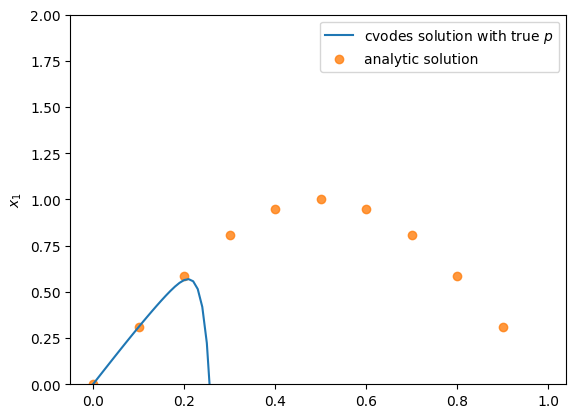

In [3]:
dt = 0.01
t_grid = np.arange(0.0, 1.0, dt)

integrator, ode, states, params = cfg.build_integrator(dt)
X_true, X_meas = dmse.generate_data(integrator, t_grid, cfg.x0, cfg.true_p, noise_std=0.0)
plt.plot(t_grid, X_true[:, 0], label='cvodes solution with true $p$')

dt = 0.1
t_grid = np.arange(0.0, 1.0, dt)

X_true = np.array([
    np.sin(np.pi * t_grid), 
    np.pi * np.cos(np.pi * t_grid), 
    t_grid]
    ).T
rng = np.random.default_rng(42)
X_meas = X_true + 0.01 * rng.standard_normal(X_true.shape)
plt.scatter(t_grid, X_true[:, 0], label='analytic solution', alpha=0.8, c='tab:orange')

plt.ylabel("$x_1$")
plt.ylim(0, 2)
plt.legend()
plt.show()

Single shooting will fail, but try our parameter estimator with multiple shooting (with different strategy for NLP)

In [4]:
print("[IPOPT]")
p_hat = dmse.estimate_p(
    ode,
    states,
    params,
    t_grid,
    X_true,
    cfg.p_init,
    num_shooting=len(t_grid),
    strategy="ipopt",
)
print(f"Estimated:\n{p_hat}")

print("[GN]")
p_hat = dmse.estimate_p(
    ode,
    states,
    params,
    t_grid,
    X_true,
    cfg.p_init,
    num_shooting=len(t_grid),
    strategy="gn",
)
print(f"Estimated:\n{p_hat}")

print("[GN_FAST]")
p_hat = dmse.estimate_p(
    ode,
    states,
    params,
    t_grid,
    X_true,
    cfg.p_init,
    num_shooting=len(t_grid),
    strategy="gn_fast",
)
print(f"Estimated:\n{p_hat}")

print(f"True:\n{np.array(cfg.true_p)}")

[IPOPT]
[estimate_p] took 2.106207s
Estimated:
[3.14]
[GN]
[gn] no improvement at iter=7, stop.
[estimate_p] took 0.063664s
Estimated:
[3.14]
[GN_FAST]
[estimate_p] took 0.320449s
Estimated:
[3.14]
True:
[3.14]


### Solve the pyridine problem

In [5]:
cfg = dmse.ModelConfig(
        name="Pyridine",
        build_integrator=dmse.pyridine_problem,
        true_p=[1.81, 0.89, 29.4, 9.21, 0.06, 2.43, 0.06, 5.5, 0.02, 0.5, 2.2],
        x0=np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
        p_init=[1.0] * 11,
        state_labels=list("ABCDEFG"),
)

dt = 0.01
t_grid = np.arange(0.0, 5.0, dt)

integrator, ode, states, params = cfg.build_integrator(dt)
X_true, X_meas = dmse.generate_data(integrator, t_grid, cfg.x0, cfg.true_p, noise_std=0.01)

print(f"#Measurement={len(t_grid)}")

#Measurement=500


[gn] no improvement at iter=4, stop.
[estimate_p] took 2.305164s
Estimated:
[ 1.80  0.90 30.85 14.20  0.06  2.72  0.05  4.28  0.02  0.53  7.95]
True:
[ 1.81  0.89 29.40  9.21  0.06  2.43  0.06  5.50  0.02  0.50  2.20]


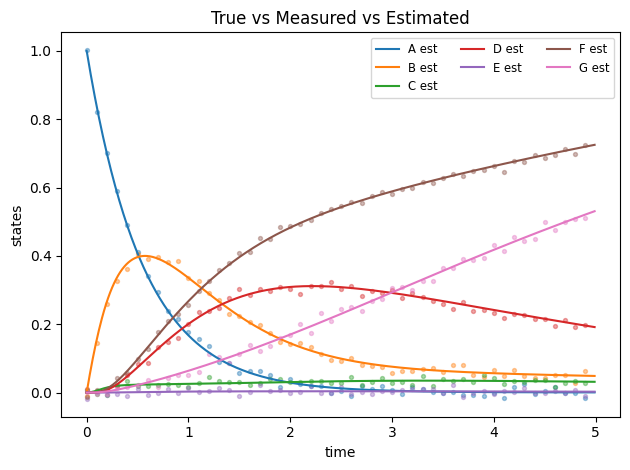

In [6]:
p_hat = dmse.estimate_p(
    ode,
    states,
    params,
    t_grid,
    X_meas,
    cfg.p_init,
    num_shooting=30,
    strategy="gn",
)

print(f"Estimated:\n{p_hat}")
print(f"True:\n{np.array(cfg.true_p)}")

X_est = dmse.simulate(integrator, t_grid, cfg.x0, p_hat)
dmse.plot(t_grid, X_meas, X_est, cfg.state_labels, show_every=10)

## Method

TODO:
- shooting(parallel)
- GN
- Schur
- IG

## Benchmark Test

TODO: Acc test

Time(s) consumed for different \#measurements, \#nodes and strategies(from `benchmark.py`)

All converge to acceptable results.

![talbe](./results/table.svg)

where **IP** is `ipopt`, **IG** is `ipopt` with the given $H = J^\top J$ and `JIT`, and **GN** is the Gauß-Newton we implement with Schur complement.

- **GN**: Gauß-Newton is optimal when the number of Nodes is small;
- **IPs**: The complexity of the IPOPT methods does not increase significantly with the number of decision variables;
- **IG**: Outstanding in large-scale because:
    1. Using $J^\top J$ saves time in computing the Hessian and good enough in least squares problems;
    2. `JIT` compiles the solver first thus saving time for each iteration.